Hello everyone,

In this project, it is required to implement an Arabic Font Identification System that will be able to identify the font for a given Arabic text snippet.
We will work with the [(ACdb) Arabic Calligraphy Database](https://drive.google.com/file/d/1dC7pwzT_RHL9B42H8-Nzf5Sant-86NV6/view) containing 9 categories of computer printed Arabic text snippets.

At first, what are the main steps we should go through in this project?

# TODOs:

1. Understand the problem (look at the big picture)
2. Get the data
3. Preprocessing
4. Extract features  
5. Features evaluation
6. Style Recognition
7. Result

# 1. Understand the problem

*What is the objective?* Despite this question appears so easy, but it is very important..

Here, the objective is --

So, we need to build a predictive model with:

- Input: --
- Output: --

In [39]:
# importing io module
import sys
# from io_utils.io_utils import read_data, read_classes, split_data
# from preprocessing.preprocessing import binarize, extract_skeleton, extract_edges, crop, separate_diacritics_and_text
# from feature_extraction.feature_extraction import Tth, SDs, WOr, LVL, HVSL, ToE_ToS, HPP 
from io_utils import io_utils
from preprocessing import preprocessing
from feature_extraction import feature_extraction 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

# reading data and class names
# classes_names = read_classes('../ACdata_base/names.txt')
# dataset_images, dataset_labels = read_data('../ACdata_base/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Get the data

After downloading and uncompressing the dataset, we will import it using --:

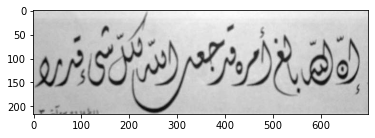

In [8]:
data, labels = io_utils.read_data("./ACdata_base")
plt.imshow(data[0], cmap="gray")
plt.show()

In [9]:
data_train, data_test, labels_train, labels_test  = io_utils.split_data(data, labels)


# 3. Preprocessing

In [10]:
def preprocessing_pipline(img):
    """apply preprocessing stages
        
    Args:
        image: grayscale image
    Returns:
        cropped_img: cropped image
        edge_img: edge image
        skeleton_img: skeleton image
        diacritics_img: diacritics only image
        text_img: text only image
    """

    binary_img = preprocessing.binarize(img)
    cropped_img = preprocessing.crop(binary_img)
    edge_img = preprocessing.extract_edges(cropped_img)
    skeleton_img = preprocessing.extract_skeleton(cropped_img)
    diacritics_img, text_img = preprocessing.separate_diacritics_and_text(cropped_img)
    
    return cropped_img, edge_img, skeleton_img, diacritics_img, text_img


# 4. Extract features

In [12]:
def feature_extraction_pipeline(cropped_img, edge_img, skeleton_img, diacritics_img, text_img):
    """apply feature extraction stages
    Args:
        cropped_img: cropped image
        edge_img: edge image
        skeleton_img: skeleton image
        diacritics_img: diacritics only image
        text_img: text only image
    Returns:
        hvsl, toe, tos, lvl, tth, sds, wor, hpp
    """    
    hvsl = feature_extraction.HVSL(edge_img)
    toe = feature_extraction.ToE_ToS(edge_img)
    tos = feature_extraction.ToE_ToS(skeleton_img)
    lvl = feature_extraction.LVL(skeleton_img)
    tth = feature_extraction.Tth(skeleton_img, edge_img)
    # sds = feature_extraction.SDs(diacritics_img)
    sds = feature_extraction.Diacritics(diacritics_img)
    wor = feature_extraction.WOr(text_img)
    hpp = feature_extraction.HPP(cropped_img)

    return hvsl, toe, tos, lvl, tth, sds, wor, hpp

In [13]:
def preprocessing_feature_extraction_pipeline(data, one_feature_vector=False):
    data_features = [[] for i in range(0,8)]
    for element in data:
        preprocessed = preprocessing_pipline(element)
        features = feature_extraction_pipeline(preprocessed[0], preprocessed[1], preprocessed[2], preprocessed[3], preprocessed[4])
        for i, feature in enumerate(features):
            data_features[i].append((feature))

    for i in range(len(data_features)):
        data_features[i] = np.vstack(data_features[i])

    if one_feature_vector:
        data_features = np.hstack(data_features)
        
    return data_features
            


# 5. Features evaluation

In [14]:
from statistics import median
from sklearn.model_selection import cross_val_score

def cross_val_classifiers(X, Y, clfs, labels=None):
    scores = []
    best_median_score = 0
    best_clf_idx = 0
    for i in range(len(clfs)):
        score = cross_val_score(clfs[i], X, Y)
        scores.append(score)
        m = median(score)
        if m > best_median_score:
            best_median_score = m
            best_clf_idx = i
    
    if labels is None:
        labels = clfs
        
    scores_df = pd.DataFrame(columns=labels, data=np.array(scores).T)
    return scores_df, best_clf_idx

In [15]:
from sklearn import metrics

def calculate_f1_score(clf, test_data, test_labels):
    pred = clf.predict(test_data)
    score_train = metrics.f1_score(test_labels, pred, average='macro')
    return score_train


## Word Orientation

In [29]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_wor = feature_extraction.WOr(text_img)
    data_features.append(features_wor)

data_features = np.array(data_features)            

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
score_wor,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Wor only with Random Forest"])

In [31]:
score_wor

Wor only with Random Forest
0                     0.486647
1                     0.513353
2                     0.531157
3                     0.501484
4                     0.451039

## Diacritics

In [44]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_diacritics = feature_extraction.Diacritics(diacritics_img)
    data_features.append(features_diacritics)

data_features = np.array(data_features)            

In [46]:
from sklearn.ensemble import RandomForestClassifier
score_diacritics,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Diacritics only with Random Forest"])

In [47]:
score_diacritics

Diacritics only with Random Forest
0                            0.341246
1                            0.382789
2                            0.412463
3                            0.454006
4                            0.415430

## HVSL

In [41]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_hvsl = feature_extraction.HVSL(edge_img)
    data_features.append(features_hvsl)

data_features = np.array(data_features)

In [42]:
from sklearn.ensemble import RandomForestClassifier
score_hvsl,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["HVSL only with Random Forest"])

In [43]:
score_hvsl

HVSL only with Random Forest
0                      0.359050
1                      0.495549
2                      0.442136
3                      0.454006
4                      0.364985

## LVL

In [23]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_lvl = feature_extraction.LVL(skeleton_img)
    data_features.append(features_lvl)

data_features = np.array(data_features)

In [24]:
score_lvl,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["LVL only with Random Forest"])

In [25]:
score_lvl

LVL only with Random Forest
0                     0.551929
1                     0.596439
2                     0.608309
3                     0.646884
4                     0.599407

## HPP

In [32]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_hpp = feature_extraction.HPP(cropped_img)
    data_features.append(features_hpp)

data_features = np.array(data_features)

In [33]:
score_hpp,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["HPP only with Random Forest"])

In [58]:
score_hpp

HPP only with Random Forest
0                     0.178042
1                     0.169139
2                     0.157270
3                     0.201780
4                     0.166172

In [35]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_toe = feature_extraction.ToE_ToS(edge_img)
    data_features.append(features_toe)

data_features = np.array(data_features)

## TOE

In [36]:
score_toe,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Toe only with Random Forest"])

In [37]:
score_toe

Toe only with Random Forest
0                     0.593472
1                     0.548961
2                     0.629080
3                     0.611276
4                     0.483680

## TOS

In [48]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_tos = feature_extraction.ToE_ToS(skeleton_img)
    data_features.append(features_tos)

data_features = np.array(data_features)

In [49]:
score_tos,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["TOS only with Random Forest"])

In [50]:
score_tos

TOS only with Random Forest
0                     0.510386
1                     0.427300
2                     0.415430
3                     0.409496
4                     0.397626

## TTH

In [51]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_tth = feature_extraction.Tth(skeleton_img, edge_img)
    data_features.append(features_tth)

data_features = np.array(data_features)

In [52]:
score_tth,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["TTH only with Random Forest"])

In [53]:
score_tth

TTH only with Random Forest
0                     0.658754
1                     0.584570
2                     0.643917
3                     0.697329
4                     0.522255

## All Features

In [59]:
scores = pd.concat((score_hpp,score_toe, score_tos, score_hvsl, score_lvl, score_tth, score_wor, score_diacritics), axis=1)

In [60]:
scores

HPP only with Random Forest  Toe only with Random Forest  \
0                     0.178042                     0.593472   
1                     0.169139                     0.548961   
2                     0.157270                     0.629080   
3                     0.201780                     0.611276   
4                     0.166172                     0.483680   

   TOS only with Random Forest  HVSL only with Random Forest  \
0                     0.510386                      0.359050   
1                     0.427300                      0.495549   
2                     0.415430                      0.442136   
3                     0.409496                      0.454006   
4                     0.397626                      0.364985   

   LVL only with Random Forest  TTH only with Random Forest  \
0                     0.551929                     0.658754   
1                     0.596439                     0.584570   
2                     0.608309                     0.643917   
3                     0.646884                     0.697329   
4                     0.599407                     0.522255   

   Wor only with Random Forest  Diacritics only with Random Forest  
0                     0.486647                            0.341246  
1                     0.513353                            0.382789  
2                     0.531157                            0.412463  
3                     0.501484                            0.454006  
4                     0.451039                            0.415430

In [61]:
scores.describe()

HPP only with Random Forest  Toe only with Random Forest  \
count                     5.000000                     5.000000   
mean                      0.174481                     0.573294   
std                       0.016969                     0.058277   
min                       0.157270                     0.483680   
25%                       0.166172                     0.548961   
50%                       0.169139                     0.593472   
75%                       0.178042                     0.611276   
max                       0.201780                     0.629080   

       TOS only with Random Forest  HVSL only with Random Forest  \
count                     5.000000                      5.000000   
mean                      0.432047                      0.423145   
std                       0.045080                      0.059258   
min                       0.397626                      0.359050   
25%                       0.409496                      0.364985   
50%                       0.415430                      0.442136   
75%                       0.427300                      0.454006   
max                       0.510386                      0.495549   

       LVL only with Random Forest  TTH only with Random Forest  \
count                     5.000000                     5.000000   
mean                      0.600593                     0.621365   
std                       0.033872                     0.068654   
min                       0.551929                     0.522255   
25%                       0.596439                     0.584570   
50%                       0.599407                     0.643917   
75%                       0.608309                     0.658754   
max                       0.646884                     0.697329   

       Wor only with Random Forest  Diacritics only with Random Forest  
count                     5.000000                            5.000000  
mean                      0.496736                            0.401187  
std                       0.030305                            0.041986  
min                       0.451039                            0.341246  
25%                       0.486647                            0.382789  
50%                       0.501484                            0.412463  
75%                       0.513353                            0.415430  
max                       0.531157                            0.454006

# Model Evaluation

In [62]:
data_train_features = preprocessing_feature_extraction_pipeline(data_train, True)

In [64]:
score_all,_ = cross_val_classifiers(data_train_features, labels_train, [RandomForestClassifier(random_state=42)])

In [65]:
score_all

RandomForestClassifier(random_state=42)
0                                 0.902655
1                                 0.893805
2                                 0.964602
3                                 0.937778
4                                 0.928889

In [68]:
random_forest_clf = RandomForestClassifier(random_state=42)
random_forest_clf.fit(data_train_features, labels_train)

RandomForestClassifier(random_state=42)

In [71]:
data_test_features = preprocessing_feature_extraction_pipeline(data_test, True)

In [77]:
from sklearn.metrics import classification_report
report = classification_report(random_forest_clf.predict(data_test_features), labels_test, output_dict=True)


In [80]:
pd.DataFrame(report).transpose()

precision    recall  f1-score     support
0              0.963636  0.929825  0.946429   57.000000
1              0.957746  0.985507  0.971429   69.000000
2              0.910448  0.938462  0.924242   65.000000
3              0.921875  0.893939  0.907692   66.000000
4              0.866667  0.912281  0.888889   57.000000
5              0.918367  0.918367  0.918367   49.000000
6              0.955882  0.955882  0.955882   68.000000
7              0.890625  0.850746  0.870229   67.000000
8              1.000000  1.000000  1.000000   59.000000
accuracy       0.931777  0.931777  0.931777    0.931777
macro avg      0.931694  0.931668  0.931462  557.000000
weighted avg   0.931969  0.931777  0.931653  557.000000

In [ ]:
# cols = (["hvsl-0","hvsl-1", "toe-0", "toe-1", "toe-2", "toe-3", "toe-4", "toe-5", "toe-6", "toe-7", "toe-8", "tos-0", "tos-1", "tos-2", "tos-3", "tos-4", "tos-5", "tos-6", "tos-7", "tos-8", "lvl-0", "lvl-1", "lvl-2", "lvl-3", "lvl-4", "tth-0", "tth-1", "tth-2", "tth-3", "tth-4", "sds", "wor", "hpp"])